In [4]:
from __future__ import division
import numpy as np
#from sklearn.gaussian_process import GaussianProcess
from scipy.optimize import minimize
from acquisition_functions import AcquisitionFunction, unique_rows
#from visualization import Visualization
from prada_gaussian_process import PradaGaussianProcess
from prada_gaussian_process import PradaMultipleGaussianProcess

from acquisition_maximization import acq_max_nlopt
from acquisition_maximization import acq_max_direct
from acquisition_maximization import acq_max
from sklearn.metrics.pairwise import euclidean_distances
import time

In [2]:
class PradaBayOptFn(object):

    def __init__(self, f, pbounds, acq='ei', verbose=1, opt='nlopt'):
        """      
        Input parameters
        ----------
        f:              function to optimize:        
        pbounds:        bounds on parameters        
        acq:            acquisition function, 'ei', 'ucb'        
        opt:            optimization toolbox, 'nlopt','direct','scipy'
        
        Returns
        -------
        dim:            dimension
        bounds:         bounds on original scale
        scalebounds:    bounds on normalized scale of 0-1
        time_opt:       will record the time spent on optimization
        gp:             Gaussian Process object
        """

        # Find number of parameters
        self.dim = len(pbounds)

        # Create an array with parameters bounds
        if isinstance(pbounds,dict):
            # Get the name of the parameters
            self.keys = list(pbounds.keys())
        
            self.bounds = []
            for key in pbounds.keys():
                self.bounds.append(pbounds[key])
            self.bounds = np.asarray(self.bounds)
        else:
            self.bounds=np.asarray(pbounds)

        # create a scalebounds 0-1
        scalebounds=np.array([np.zeros(self.dim), np.ones(self.dim)])
        self.scalebounds=scalebounds.T
        
        self.max_min_gap=self.bounds[:,1]-self.bounds[:,0]
        
        # Some function to be optimized
        self.f = f
        # optimization toolbox
        self.opt=opt
        # acquisition function type
        self.acq=acq
        
        # store X in original scale
        self.X_original= None

        # store X in 0-1 scale
        self.X = None
        
        # store y=f(x)
        self.Y = None
        
        self.time_opt=0


        self.k_Neighbor=2
        
        # Lipschitz constant
        self.L=0
        
        
        # Gaussian Process class
        self.gp=PradaGaussianProcess

        # acquisition function
        self.acq_func = None
    
    # will be later used for visualization
    def posterior(self, Xnew):
        self.gp.fit(self.X, self.Y)
        mu, sigma2 = self.gp.predict(Xnew, eval_MSE=True)
        return mu, np.sqrt(sigma2)
    
    
    def init(self, gp_params, n_init_points=3):
        """      
        Input parameters
        ----------
        gp_params:            Gaussian Process structure      
        n_init_points:        # init points
        """

        # Generate random points
        l = [np.random.uniform(x[0], x[1], size=n_init_points) for x in self.bounds]

        # Concatenate new random points to possible existing
        # points from self.explore method.
        temp=np.asarray(l)
        temp=temp.T
        init_X=list(temp.reshape((n_init_points,-1)))
        
        self.X_original = np.asarray(init_X)
        
        # Evaluate target function at all initialization           
        y_init=self.f(init_X)
        y_init=np.reshape(y_init,(n_init_points,1))
        self.Y = np.asarray(y_init)
        
        # convert it to scaleX
        temp_init_point=np.divide((init_X-self.bounds[:,0]),self.max_min_gap)
        
        self.X = np.asarray(temp_init_point)

In [1]:
import ppo_functions as pfunctions
import numpy as np

In [2]:
myfunction = pfunctions.PpoImport()
pbounds = myfunction.bounds
print (myfunction.bounds)
print (len(myfunction.bounds))

gp_params = {'theta':0.1*2,'noise_delta':0.1}

print (gp_params)

# Create an array with parameters bounds
if isinstance(pbounds,dict):
    # Get the name of the parameters
    keys = list(pbounds.keys())

    bounds = []
    for key in pbounds.keys():
        bounds.append(pbounds[key])
    bounds = np.asarray(bounds)
else:
    bounds=np.asarray(pbounds)
    
print (bounds)

OrderedDict([('lambda', (0, 1)), ('gamma', (0, 1))])
2
{'theta': 0.2, 'noise_delta': 0.1}
[[0 1]
 [0 1]]


In [3]:
print (myfunction.name)

ppoGAE_import2


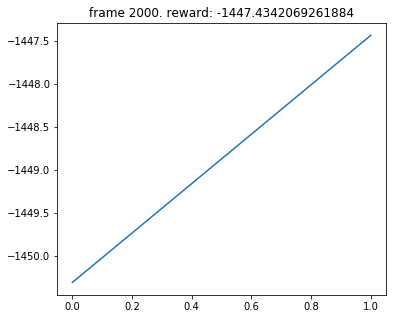

rewards:  -1447.4342069261884
loss:  [tensor(0.1107, device='cuda:0')]
func_re:  [0.1988288015127182, 0.2397281974554062, 0.11073378473520279]
y_init:  [0.1988288015127182, 0.2397281974554062, 0.11073378473520279]


In [4]:
# Generate random points
l = [np.random.uniform(x[0], x[1], size=3) for x in bounds]

n_init_points = 3

print (l)

temp=np.asarray(l)
temp=temp.T
init_X=list(temp.reshape((n_init_points,-1)))

print (init_X)

X_original = np.asarray(init_X)

# Evaluate target function at all initialization           
y_init=myfunction.func(init_X)
print ("y_init: ", y_init)

y_init=np.reshape(y_init,(n_init_points,1))
Y = np.asarray(y_init)

In [7]:
max_min_gap=bounds[:,1]-bounds[:,0]

temp_init_point=np.divide((init_X-bounds[:,0]),max_min_gap)

print ("Temp: ", temp_init_point)

X = np.asarray(temp_init_point)

print ("X", X)

Temp:  [[0.24918405 0.81934347]
 [0.49503057 0.91874498]
 [0.55723222 0.0184111 ]]
X [[0.24918405 0.81934347]
 [0.49503057 0.91874498]
 [0.55723222 0.0184111 ]]


In [ ]:
#     def init(self, gp_params, n_init_points=3):
        """      
        Input parameters
        ----------
        gp_params:            Gaussian Process structure      
        n_init_points:        # init points
        """

# # Generate random points
# l = [np.random.uniform(x[0], x[1], size=3) for x in myfunction.bounds]

# print (l)

# Concatenate new random points to possible existing
# points from self.explore method.
temp=np.asarray(l)
temp=temp.T
init_X=list(temp.reshape((n_init_points,-1)))

self.X_original = np.asarray(init_X)

# Evaluate target function at all initialization           
y_init=self.f(init_X)
y_init=np.reshape(y_init,(n_init_points,1))
self.Y = np.asarray(y_init)

# convert it to scaleX
temp_init_point=np.divide((init_X-self.bounds[:,0]),self.max_min_gap)

self.X = np.asarray(temp_init_point)